<a href="https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/Inverse_Black_Scholes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Black-Scholes Partial Differential Equation (PDE)
The value of an option $V(S, t)$ satisfies the Black-Scholes PDE:
$$
\frac{\partial V}{\partial t} + \frac{1}{2} \sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + r S \frac{\partial V}{\partial S} - r V = 0
$$

### Initial and Boundary Conditions of the Black-Scholes PDE

The initial and boundary conditions for the Black-Scholes PDE depend on the type of derivative being priced, such as European call or put options. These conditions are necessary for solving the PDE and obtaining specific option prices. We will consider a Call option.

- $\textbf{Initial Condition}$ (at $t = T$):
    - $\text{Call: } V(S, T) = \max(S - K, 0)$ \\
- $\textbf{Boundary Conditions:}$
  - $V(0, t) = 0$ \\
  - $V(S, t) \to S - K e^{-r(T-t)} \quad \text{as } S \to \infty$

These conditions, combined with the Black-Scholes PDE, provide a complete specification for determining the price of the option.


## Implementation

In [170]:
import torch
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

## Analytic formula

In [171]:
def black_scholes(S, t, T=1.0, K=120, r=0.05, sigma=0.20, option_type="call"):
    """
    Compute the Black-Scholes option price.

    Args:
        S (torch.Tensor): Current stock price.
        T (float): Time to maturity.
        t (float): Current time (typically 0).
        K (float): Strike price.
        r (float): Risk-free interest rate.
        sigma (float): Volatility of the stock price.
        option_type (str): "call" or "put".

    Returns:
        torch.Tensor: Option price.
    """
    # Ensure inputs are PyTorch tensors and have the correct dtype
    S = torch.tensor(S, dtype=torch.float32) # Convert S0 to a PyTorch tensor

    # Time to maturity
    tau = T - t

    # Avoid division by zero for tau = 0
    epsilon = 1e-8

    # Convert r and tau to tensors
    r = torch.tensor(r, dtype=torch.float32)
    tau = torch.tensor(tau, dtype=torch.float32)

    # Compute d1 and d2
    # Use tau and epsilon directly for torch.sqrt, no need to create new tensors
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * torch.sqrt(tau + epsilon))
    d2 = d1 - sigma * torch.sqrt(tau + epsilon)

    # Compute N(d1) and N(d2) using the cumulative distribution function
    N_d1 = 0.5 * (1.0 + torch.erf(d1 / torch.sqrt(torch.tensor(2.0))))
    N_d2 = 0.5 * (1.0 + torch.erf(d2 / torch.sqrt(torch.tensor(2.0))))

    # Compute the call or put price
    if option_type == "call":
        option_price = S * N_d1 - K * torch.exp(-r * tau) * N_d2
    elif option_type == "put":
        option_price = K * torch.exp(-r * tau) * (1.0 - N_d2) - S * (1.0 - N_d1)
    else:
        raise ValueError("Invalid option_type. Must be 'call' or 'put'.")

    return option_price

In [172]:
def bs_pde_residual(model, S, t, r=0.05, sigma=0.20):
    """
    Compute the PDE residual for Black-Scholes equation:
    """
    S.requires_grad = True
    t.requires_grad = True
    V = model(torch.cat((S, t), dim=1))

    # Gradients w.r.t. x and t
    V_S = torch.autograd.grad(V, S, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]

    # Second-order derivative w.r.t. S
    V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]

    # PDE residual
    residual = V_t + 0.5*sigma**2*S**2*V_SS + r*S*V_S -r*V
    return residual

# Step 2: Define the PINN model
class PINN(nn.Module):
    """Physics-Informed Neural Network for heat equation."""
    def __init__(self):
        super(PINN, self).__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(2, 50),  # Inputs: (s, t)
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: V(s, t)
        )

    def forward(self, s):
        return self.hidden_layers(s)

# Step 3: Define the loss function
def compute_loss(model, s_interior, t_interior, s_boundary, t_boundary,
                 s_initial, t_initial, V_initial,
                 r, sigma):
    """Compute the combined loss for the PDE residual, boundary, and initial conditions."""
    # PDE residual loss
    residual = bs_pde_residual(model, s_interior, t_interior, r, sigma)
    pde_loss = torch.mean(residual**2)

    # Boundary condition loss:
    # V(0, t)=0
    # V(S, t)→S-K*exp(−r(T−t))as 𝑆→∞
    V_boundary_left = model(torch.cat((s_boundary[0], t_boundary), dim=1))
    V_boundary_right = model(torch.cat((s_boundary[1], t_boundary), dim=1))
    bc_loss = torch.mean(V_boundary_left**2) + torch.mean(V_boundary_right**2)

    # Initial condition loss:
    # (at 𝑡=𝑇): 𝑉(𝑆,𝑇)=max(𝑆−𝐾,0)
    V_initial_pred = model(torch.cat((s_initial, t_initial), dim=1))
    ic_loss = torch.mean((V_initial_pred - V_initial)**2)

    return pde_loss + bc_loss + ic_loss


# Step 4: Training the model
def train_pinn(model, s_interior, t_interior, s_boundary, t_boundary,
               s_initial, t_initial, V_initial,
               r, sigma, adam_epochs=1000, lbfgs_epochs=500):
    """Train the PINN model using Adam and LBFGS optimizers."""
    # Adam optimizer for initial training
    optimizer_adam = torch.optim.Adam(model.parameters(), lr=0.0001)
    for epoch in range(adam_epochs):
        optimizer_adam.zero_grad()
        loss = compute_loss(model, s_interior, t_interior, s_boundary,
                            t_boundary, s_initial, t_initial, V_initial,
                            r, sigma)
        loss.backward()
        optimizer_adam.step()
        if epoch % 100 == 0:
            print(f"Adam Epoch {epoch}, Loss: {loss.item()}")

    # LBFGS optimizer for fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=lbfgs_epochs,
                                        tolerance_grad=1e-7, tolerance_change=1e-9)

    def closure():
        optimizer_lbfgs.zero_grad()
        loss = compute_loss(model, s_interior, t_interior, s_boundary, t_boundary,
                            s_initial, t_initial, V_initial, r, sigma)
        loss.backward()
        return loss

    print("Starting LBFGS optimization...")
    optimizer_lbfgs.step(closure)

In [173]:
S_max = 150.0
S_min = 50.0
strike = 100.0
T = 1.0
r = 0.05
sigma = 0.2

S = torch.linspace(S_min, S_max, 100).view(-1, 1)
t = torch.linspace(0, T, 100).view(-1, 1)

# Create mesh grid for interior points
S_grid, t_grid = torch.meshgrid(S.squeeze(), t.squeeze(), indexing='ij')
S_interior = S_grid.flatten().view(-1, 1)
t_interior = t_grid.flatten().view(-1, 1)

# Boundary points
# V(0, t)=0
# V(S, t)→S-K*exp(−r(T−t))as 𝑆→∞
S_goes_infinity = 1.0 -strike*torch.exp(-torch.tensor(r)*torch.tensor(T))
S_boundary = [torch.full_like(t, 0), torch.full_like(t, S_goes_infinity)]
t_boundary = t

# Initial points
# (at 𝑡=𝑇): 𝑉(𝑆, 𝑇)=max(𝑆−𝐾, 0)
S_initial = S
t_initial = torch.full_like(t, T)
V_initial = torch.max(S - strike, torch.tensor(0.0))

In [174]:
# Step 6: Initialize and train the PINN
model = PINN()
train_pinn(model, S_interior, t_interior, S_boundary, t_boundary, S_initial,
           t_initial, V_initial,
           r, sigma,
           adam_epochs=500, lbfgs_epochs=5000)

Adam Epoch 0, Loss: 420.87115478515625
Adam Epoch 100, Loss: 385.4375305175781
Adam Epoch 200, Loss: 362.4284973144531
Adam Epoch 300, Loss: 351.0783386230469
Adam Epoch 400, Loss: 344.60650634765625
Starting LBFGS optimization...


In [57]:
# Create a grid for prediction
S_pred = torch.linspace(S_min, S_max, 100).view(-1, 1)
t_pred = torch.linspace(0, T, 100).view(-1, 1)

S_grid_pred, t_grid_pred = torch.meshgrid(S_pred.squeeze(), t_pred.squeeze(),
                                          indexing='ij')
S_flat = S_grid_pred.flatten().view(-1, 1)
t_flat = t_grid_pred.flatten().view(-1, 1)

# Predict using the trained model
V_pred = model(torch.cat((S_flat, t_flat), dim=1)).detach().numpy()
V_pred = V_pred.reshape(100, 100)

In [58]:
V_pred

array([[12.594782, 12.594782, 12.594782, ..., 12.594782, 12.594782,
        12.594782],
       [12.594782, 12.594782, 12.594782, ..., 12.594782, 12.594782,
        12.594782],
       [12.594782, 12.594782, 12.594782, ..., 12.594782, 12.594782,
        12.594782],
       ...,
       [12.59478 , 12.59478 , 12.59478 , ..., 12.59478 , 12.59478 ,
        12.59478 ],
       [12.59478 , 12.59478 , 12.59478 , ..., 12.59478 , 12.59478 ,
        12.59478 ],
       [12.59478 , 12.59478 , 12.59478 , ..., 12.59478 , 12.59478 ,
        12.59478 ]], dtype=float32)

In [60]:
# black_scholes(S, t, T, K, r, sigma)
V_exact = black_scholes(S_flat, t_flat, T, strike, r, sigma)
V_exact = V_exact.reshape(100, 100)
V_exact

<ipython-input-53-57165c588757>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tau = torch.tensor(tau, dtype=torch.float32)


tensor([[2.3988e-03, 2.2240e-03, 2.0613e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.5019e-03, 3.2586e-03, 3.0289e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [5.0266e-03, 4.6938e-03, 4.3780e-03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [5.2969e+01, 5.2918e+01, 5.2867e+01,  ..., 4.8081e+01, 4.8030e+01,
         4.7980e+01],
        [5.3969e+01, 5.3918e+01, 5.3867e+01,  ..., 4.9091e+01, 4.9040e+01,
         4.8990e+01],
        [5.4970e+01, 5.4919e+01, 5.4868e+01,  ..., 5.0101e+01, 5.0050e+01,
         5.0000e+01]])

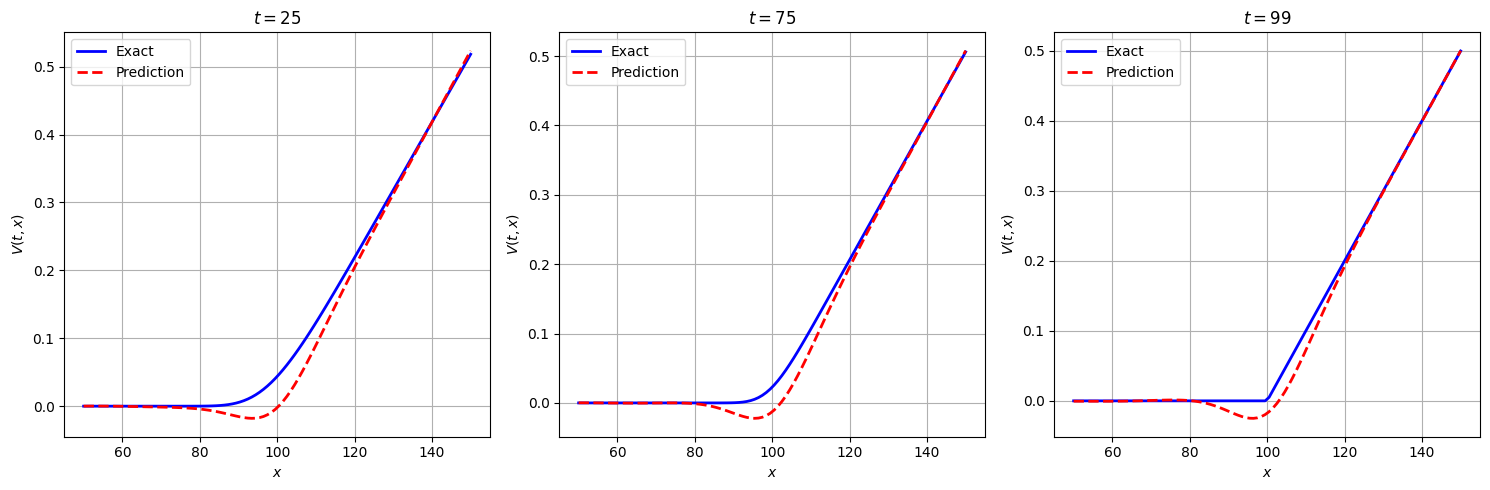

In [51]:
# Step 8: Compare predictions with exact solution at specific time slices
time_slices = [25, 75, 99]  # Time slices to compare

# Denormalize S_pred for plotting
d_S_pred = S_pred * (S_max - S_min) + S_min

plt.figure(figsize=(15, 5))

for i, t_slice in enumerate(time_slices):
    # Extract points for the time slice
    t_slice_tensor = torch.full_like(S_pred, t_slice)
    V_pred_slice = V_pred[:, t_slice]

    # Compute exact solution
    V_exact_slice = V_exact[:,t_slice]

    # Plot comparison
    plt.subplot(1, 3, i + 1)
    plt.plot(d_S_pred.numpy(), V_exact_slice, 'b-', label='Exact', linewidth=2)
    plt.plot(d_S_pred.numpy(), V_pred_slice, 'r--', label='Prediction', linewidth=2)
    plt.title(f"$t = {t_slice}$")
    plt.xlabel("$x$")
    plt.ylabel("$V(t, x)$")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm # Import the norm object from scipy.stats

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 50)  # Input now includes S, t, and K
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the PDE residual
def pde_residual(model, S, t, K, sigma, r):
    V = model(torch.cat([S, t, K], dim=1))
    V_t = torch.autograd.grad(V, t, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_S = torch.autograd.grad(V, S, grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S, S, grad_outputs=torch.ones_like(V_S), create_graph=True)[0]
    residual = V_t + 0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V
    return residual

# Define the loss function
def loss_function(model, S, t, K, sigma, r, option_prices, S_boundary, t_boundary, K_boundary, T):
    residual = pde_residual(model, S, t, K, sigma, r)
    boundary_loss = torch.mean((model(torch.cat([S, t, K], dim=1)) - option_prices)**2)
    pde_loss = torch.mean(residual**2)

    # Initial condition loss
    V_T = model(torch.cat([S, torch.ones_like(t) * T, K], dim=1))
    initial_condition_loss = torch.mean((V_T - torch.max(S - K, torch.zeros_like(S)))**2)

    # Boundary condition loss
    V_0 = model(torch.cat([torch.zeros_like(S_boundary), t_boundary[0].expand_as(S_boundary), K_boundary], dim=1))
    boundary_condition_loss_1 = torch.mean(V_0**2)

    V_inf = model(torch.cat([S_boundary, t_boundary[1].expand_as(S_boundary), K_boundary], dim=1))
    boundary_condition_loss_2 = torch.mean((V_inf - (S_boundary - K_boundary * torch.exp(-r * (T - t[0]))))**2)

    return boundary_loss + pde_loss + initial_condition_loss + boundary_condition_loss_1 + boundary_condition_loss_2

# Training the model
def train(model, S, t, K, sigma, r, option_prices, S_boundary, t_boundary, K_boundary, T, epochs=1000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = loss_function(model, S, t, K, sigma, r, option_prices, S_boundary, t_boundary, K_boundary, T)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

# Prediction function
def predict(model, S, t, K):
    model.eval()
    with torch.no_grad():
        prediction = model(torch.cat([S, t, K], dim=1))
    return prediction

# Analytic solution for European call option
def analytic_solution(S, K, T, t, sigma, r):
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * torch.sqrt(T - t))
    d2 = d1 - sigma * torch.sqrt(T - t)
    # Detach d1 and d2 before calling norm.cdf and converting to tensors
    return S * torch.tensor(norm.cdf(d1.detach().numpy())) - K * torch.exp(-r * (T - t)) * torch.tensor(norm.cdf(d2.detach().numpy()))

# Plot predictions against analytic solution
def plot_predictions(S, t, K, predictions, T, sigma, r):
    analytic_prices = analytic_solution(S, K, T, t, sigma, r)
    plt.plot(S.detach().numpy(), predictions.detach().numpy(), 'b', label='Predicted')
    plt.plot(S.detach().numpy(), analytic_prices.detach().numpy(), 'r--', label='Analytic')
    plt.xlabel('Stock Price (S)')
    plt.ylabel('Option Price')
    plt.legend()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Example data (replace with actual data)
    S = torch.tensor([[50.0], [60.0], [70.0]], requires_grad=True)
    t = torch.tensor([[0.1], [0.2], [0.3]], requires_grad=True)
    K = torch.tensor([[50.0], [60.0], [70.0]])  # K is not trainable
    option_prices = torch.tensor([[5.0], [6.0], [7.0]])
    sigma = 0.2
    r = 0.05
    T = 1.0  # Maturity

    # Boundary conditions data
    S_boundary = torch.tensor([[0.0], [100.0]], requires_grad=True)
    t_boundary = torch.tensor([[0.0], [1.0]], requires_grad=True)
    K_boundary = torch.tensor([[50.0], [60.0]])

    model = PINN()
    train(model, S, t, K, sigma, r, option_prices, S_boundary, t_boundary, K_boundary, T)

In [100]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.9 MB/s eta 0:00:00
